# Hello PyBullet!

This notebook shows how to install and create a simple application on PyBullet.

## Setup

First, let's install the [PyBullet](https://pybullet.org/wordpress/) module.


In [1]:
# Install the PyBullet module.
!pip install -U pybullet

     |████████████████████████████████| 90.8 MB 245 bytes/s 


## Hello PyBullet World!

This is based on the
[PyBullet Quickstart Guide](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit?usp=sharing).

After importing the PyBullet module, the first thing to do is 'connecting' to the physics simulation.
PyBullet is designed around a client-server driven API, with a client sending commands and a physics server returning the status.

PyBullet has some built-in physics servers: `DIRECT` and `GUI`.
Both `GUI` and `DIRECT` connections will execute the physics simulation and rendering in the same process as PyBullet.

In this example, we'll use the `DIRECT` mode to do the calculations independently of rendering.

In [1]:
import pybullet as p

p.connect(p.DIRECT)

0

We want to access the example
[Bullet data](https://github.com/bulletphysics/bullet3/tree/master/data)
files.
Fortunately, we can specify a new search path in PyBullet and point it to the `py_bullet_data.getDataPath()`.

In [2]:
import pybullet_data

p.setAdditionalSearchPath(pybullet_data.getDataPath())

Now, we can load models from the example data in the
[Unified Robot Description Format (URDF)](https://wiki.ros.org/urdf) format.

Let's load a `plane` to serve as our simulation floor plane,
and an [R2D2 droid](https://en.wikipedia.org/wiki/R2-D2).

In Bullet Physics, you can use whatever units you want as long as you are consistent.
For this example, we'll use the
[metric system](https://en.wikipedia.org/wiki/Metric_system).

In [4]:
# First, let's make sure we start with a fresh new simulation.
# Otherwise, we can keep adding objects by running this cell over again.
p.resetSimulation()

# Load our simulation floor plane at the origin (0, 0, 0).
p.loadURDF('plane.urdf')

# Load an R2D2 droid at the position at 0.5 meters height in the z-axis.
r2d2 = p.loadURDF('./diva_teleop_boxy.urdf')

# We can check the number of bodies we have in the simulation.
p.getNumBodies()

error: Cannot load URDF file.

### Joint information

Now that we've populated our simulation with those two objects,
we can analyze them to see what's inside.

The [`getJointInfo()`](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit?usp=sharing#heading=h.la294ocbo43o)
function returns a list of all the information from the selected joint.

In [5]:
# First let's define a class for the JointInfo.
from dataclasses import dataclass

@dataclass
class Joint:
  index: int
  name: str
  type: int
  gIndex: int
  uIndex: int
  flags: int
  damping: float
  friction: float
  lowerLimit: float
  upperLimit: float
  maxForce: float
  maxVelocity: float
  linkName: str
  axis: tuple
  parentFramePosition: tuple
  parentFrameOrientation: tuple
  parentIndex: int

  def __post_init__(self):
    self.name = str(self.name, 'utf-8')
    self.linkName = str(self.linkName, 'utf-8')

# Let's analyze the R2D2 droid!
print(f"r2d2 unique ID: {r2d2}")
for i in range(p.getNumJoints(r2d2)):
  joint = Joint(*p.getJointInfo(r2d2, i))
  print(joint)

r2d2 unique ID: 1
Joint(index=0, name='base_to_right_leg', type=4, gIndex=-1, uIndex=-1, flags=0, damping=0.0, friction=0.0, lowerLimit=0.0, upperLimit=-1.0, maxForce=0.0, maxVelocity=0.0, linkName='right_leg', axis=(0.0, 0.0, 0.0), parentFramePosition=(0.22, 0.0, 0.25), parentFrameOrientation=(0.0, -0.7070904020014416, 0.0, 0.7071231599922604), parentIndex=-1)
Joint(index=1, name='right_base_joint', type=4, gIndex=-1, uIndex=-1, flags=0, damping=0.0, friction=0.0, lowerLimit=0.0, upperLimit=-1.0, maxForce=0.0, maxVelocity=0.0, linkName='right_base', axis=(0.0, 0.0, 0.0), parentFramePosition=(0.2999999996780742, 0.0, -1.3898038463944216e-05), parentFrameOrientation=(0.0, 0.7070904020014416, 0.0, 0.7071231599922604), parentIndex=0)
Joint(index=2, name='right_front_wheel_joint', type=0, gIndex=7, uIndex=6, flags=1, damping=0.0, friction=0.0, lowerLimit=0.0, upperLimit=-1.0, maxForce=100.0, maxVelocity=100.0, linkName='right_front_wheel', axis=(0.0, 0.0, 1.0), parentFramePosition=(0.0, 0.

To start the simulation, first we must set the gravity.
We'll use [Earth's gravity](http://www.geophys.ac.cn/infowin/Gravity.asp) for convenience, so we'll set it up to `-9.807` m/s<sup>2</sup>.

In [8]:
# Set the gravity to Earth's gravity.
p.setGravity(0, 0, -9.807)

# Run the simulation for a fixed amount of steps.
# for i in range(20):
#     position, orientation = p.getBasePositionAndOrientation(r2d2)
#     x, y, z = position
#     roll, pitch, yaw = p.getEulerFromQuaternion(orientation)
#     print(f"{i:3}: x={x:0.10f}, y={y:0.10f}, z={z:0.10f}), roll={roll:0.10f}, pitch={pitch:0.10f}, yaw={yaw:0.10f}")
#     p.stepSimulation()

### Rendering

The [`getCameraImage`](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit?usp=sharing#heading=h.u1jisfnt6984)
API will return a RGB image, a depth buffer and a segmentation mask buffer with body unique ids of visible objects for each pixel

rgba shape=(200, 320, 4), dtype=uint8


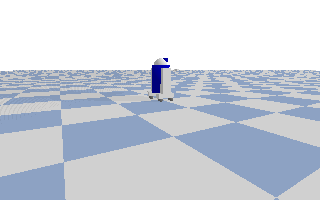

depth shape=(200, 320), dtype=float32, as values from 0.0 (near) to 1.0 (far)


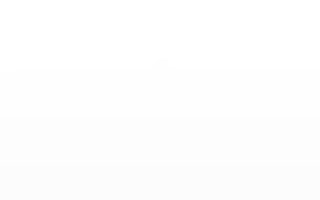

mask shape=(200, 320), dtype=int32, as unique values from 0 to N-1 entities, and -1 as None


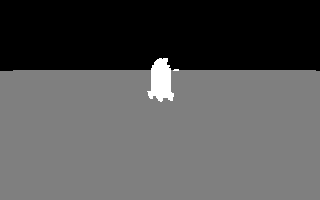

In [7]:
import numpy as np
from PIL import Image
from IPython.display import display

width = 320
height = 200
img_arr = p.getCameraImage(
    width,
    height,
    viewMatrix=p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=[0, 0, 0],
        distance=4,
        yaw=60,
        pitch=-10,
        roll=0,
        upAxisIndex=2,
    ),
    projectionMatrix=p.computeProjectionMatrixFOV(
        fov=60,
        aspect=width/height,
        nearVal=0.01,
        farVal=100,
    ),
    shadow=True,
    lightDirection=[1, 1, 1],
)

width, height, rgba, depth, mask = img_arr
print(f"rgba shape={rgba.shape}, dtype={rgba.dtype}")
display(Image.fromarray(rgba, 'RGBA'))
print(f"depth shape={depth.shape}, dtype={depth.dtype}, as values from 0.0 (near) to 1.0 (far)")
display(Image.fromarray((depth*255).astype('uint8')))
print(f"mask shape={mask.shape}, dtype={mask.dtype}, as unique values from 0 to N-1 entities, and -1 as None")
display(Image.fromarray(np.interp(mask, (-1, mask.max()), (0, 255)).astype('uint8')))